# Predict Home Prices Using Linear Regression


## Deliverables:

1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [1]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import median_absolute_error, r2_score
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from pygam import LogisticGAM, LinearGAM, s, f, te
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from scipy import sparse
import models

***

## <font color = Blue>Data Import and Wrangling</font>


In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30


In [4]:
# check DF tail
df.tail(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [8]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [9]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [10]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [11]:
# add some logrithmic variables
df['log2sf'] = np.log2(df['square_feet'])
df['log2lot_size'] = np.log2(df['lot_size'])
df['log2value'] = np.log2(df['assessed_value'])
df['age'] = 2000-df.year_built

## <font color = Blue> Continue Data Exploration. Also example of feature engineering. Created a column (median price of zipcode the home is in). We can try to see how this feature help in predicting home prices</font>

In [12]:
#add median home value to each row for corresponding zip_code. Also added a log2value for zip_median
zip1 = df.zip_code
list1 = list(zip1)
(df[df.zip_code == list1[3]]).assessed_value.median()

def median_v(df, l):
    list2 = []
    for i in range(0, len(l)):
        median1 = (df[df.zip_code == l[i]]).assessed_value.median()
        list2.append(median1)
    return list2

list3 = median_v(df, list1)
list3 = pd.DataFrame(list3, columns=['zip_median'])
df = pd.concat([df, list3], axis=1)
df['log2_zip_median'] = np.log2(df['zip_median'])

In [13]:
#Calculate Haversine distance using latitude and longitude data. Note that I have selected a random referencepoint
#LA (lat2 = 34.724, lon2 = -117.882)

from math import radians, sin, cos, sqrt, asin
 
 
def haversine(lat1, lon1):
    lat2 = 34.724
    lon2 = -117.882
    R = 6372.8  # Earth radius in kilometers
 
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
 
    a = sin(dLat / 2)**2 + cos(lat1) * cos(lat2) * sin(dLon / 2)**2
    c = 2 * asin(sqrt(a))
 
    return R * c

In [14]:
#create a new column 'Haversine distance'
df['haversine_distance'] = [haversine(x, y) for x, y in zip(df.latitude/1000000, df.longitude/1000000)]

In [15]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median,haversine_distance
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,...,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30,144172.0,17.137431,21.546420
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,...,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89,162337.0,17.308632,88.899173


In [16]:
# save data in a .csv file
#df.to_csv('zillow_cleaned1.csv')

In [17]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [18]:
#create a subset of df with continuous variables to create pairplot
train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'haversine_distance', 'assessed_value']]

In [19]:
#df.groupby(['zip_code']).agg(['mean', 'count'])

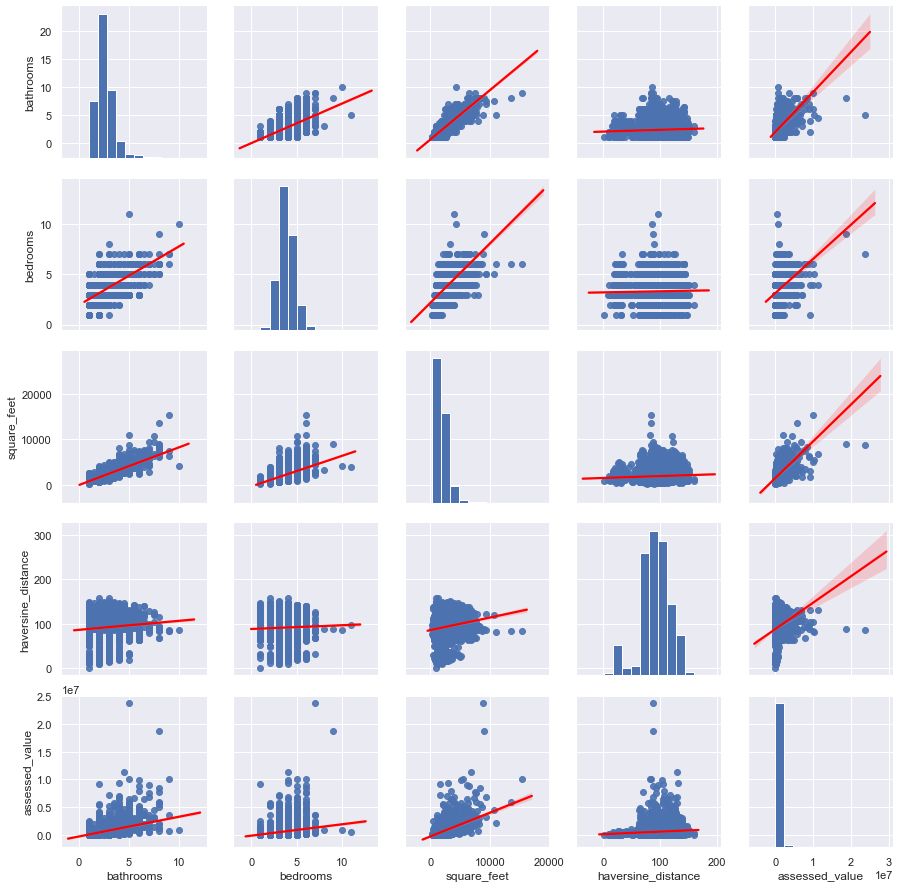

In [20]:
explore.plot_variable_pairs(train_plot)

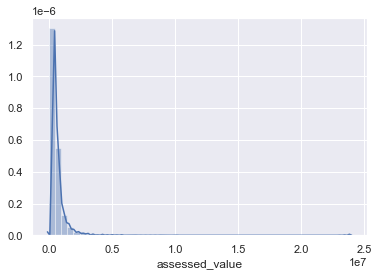

In [21]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [22]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,haversine_distance,assessed_value
bathrooms,1.000000,0.641827,0.854944,0.079816,0.505229
bedrooms,0.641827,1.000000,0.628387,0.030077,0.263875
square_feet,0.854944,0.628387,1.000000,0.108428,0.588502
haversine_distance,0.079816,0.030077,0.108428,1.000000,0.164899
assessed_value,0.505229,0.263875,0.588502,0.164899,1.000000


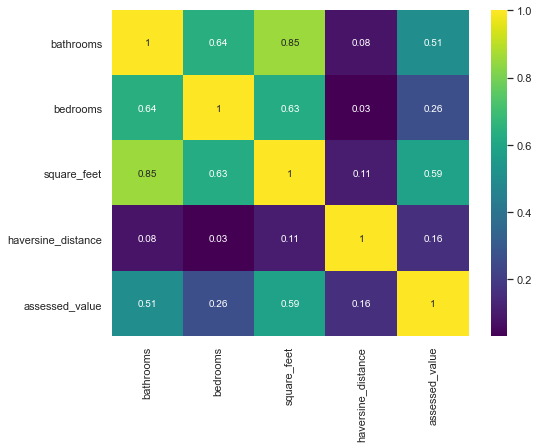

In [23]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

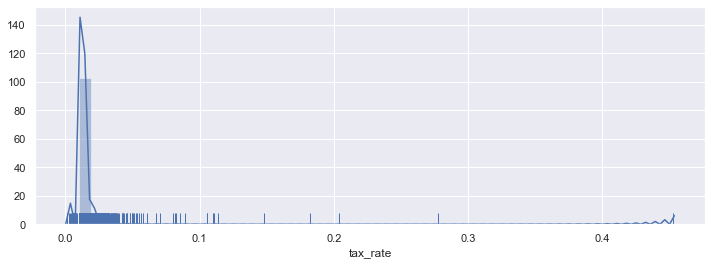

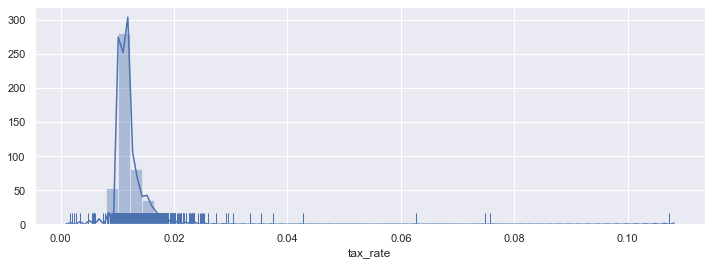

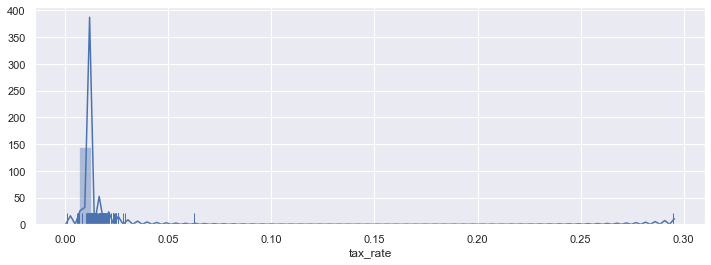

In [24]:
plt.figure(figsize=(12,4))
# below are plots for tax_rate distributions in three counties
sns.distplot(df[df.County == 'Los Angles'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Orange'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Ventura'].tax_rate, rug=True)

## Lets do some hypothesis testing 

## $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
## $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [25]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['log2sf', 'log2_zip_median']]
y_train = train[['log2value']]
X_test = test[['log2sf', 'log2_zip_median']]
y_test = test[['log2value']]

In [26]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.log2value
})
predictions.head(2)

,actual
11938,18.034869
790,16.548476


In [27]:
#predictions['median_bl'] =  train['assessed_value'].median()
#predictions['mean_bl'] =  train['assessed_value'].mean()

In [28]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('log2value ~ log2sf + log2_zip_median',  data = train).fit()

# compute predictions and add to original dataframe
predictions['ols'] = ols_model.predict(X_train)

In [29]:
predictions['actual1'] =  2**predictions['actual']
predictions['predicted1'] =  2**predictions['ols']

In [30]:
predictions.head(2)

,actual,ols,actual1,predicted1
11938,18.034869,18.076219,268557.0,276365.741143
790,16.548476,18.701583,95849.0,426321.757095


In [31]:
#pd.options.display.float_format = '{:.3f}'.format
#predictions.apply(lambda col: median_absolute_error(predictions.actual1, col))

float('{:.1f}'.format(median_absolute_error(predictions.actual1, predictions.predicted1)))

153470.4

In [32]:
#pd.options.display.float_format = '{:.3f}'.format
#predictions.apply(lambda col: r2_score(predictions.actual1, col))

float('{:.3f}'.format(r2_score(predictions.actual1, predictions.predicted1)))

0.424

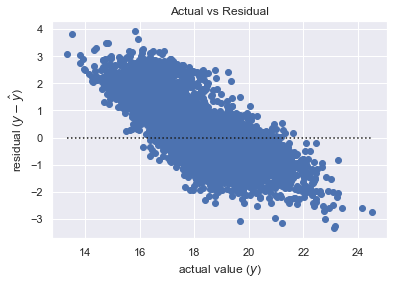

In [33]:
#Lets look at residuals (Log Values)
evaluate.plot_residuals(predictions.actual, predictions.ols, predictions)



##  Looks like there is a clear trend. The model seems overestimating lower home prices, but under-estimates significantly at higher price levels. 

In [34]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log2value   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     4082.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:41:37   Log-Likelihood:                -15052.
No. Observations:               10411   AIC:                         3.011e+04
Df Residuals:                   10408   BIC:                         3.013e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.1794      0.244    -13.009      0.000      -3.658      -2.700
log2sf              0.7889      0.018     44.491      0.000       0.754       0.824
log2_zip_median     0.7015      0.014     50.320      0.000       0.674       0.729
==============================================================================
Omnibus:                      941.276   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1215.806
Skew:                          -0.830   Prob(JB):                    9.80e-265
Kurtosis:                       3.217   Cond. No.                         525.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##  Since my p-value is <0.05, I can reject the null hypothesis.
##  This means that there is statistically significant relationship between home prices and  independent variables used above.

***

# Lets apply this model on test data and see how it performs

In [35]:
y_test['y_ols'] = ols_model.predict(X_test)

In [36]:
y_test['actual1'] =  2**y_test['log2value']
y_test['predicted1'] =  2**y_test['y_ols']

In [37]:
#y_test.apply(lambda col: median_absolute_error(y_test.actual1, col))

float('{:.1f}'.format(median_absolute_error(y_test.actual1, y_test.predicted1)))

149755.2

In [38]:
float('{:.3f}'.format(r2_score(y_test.actual1, y_test.predicted1)))

0.454

## The Median Absolute Error for test data is comparable to train data which means that model is not overfitted

***

## Let's do more data exploration, but looking at log(base2)  values of home prices and square feet and median zip values

(8.0, 26.0)

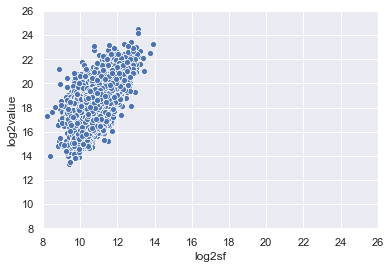

In [39]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2sf', y = 'log2value', data=train, ax = ax)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

(8.0, 26.0)

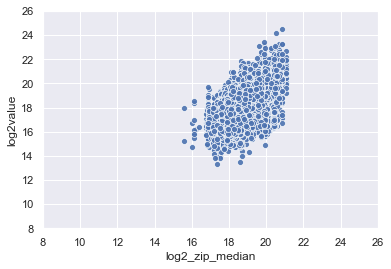

In [40]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2_zip_median', y = 'log2value', data=train,alpha=0.9)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

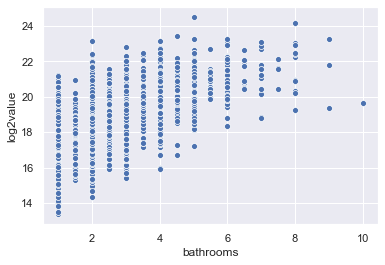

In [41]:
sns.scatterplot(x='bathrooms', y = 'log2value', data=train)

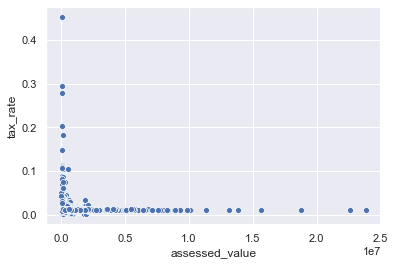

In [42]:
sns.scatterplot(x='assessed_value', y = 'tax_rate', data=df)

## Tax rate seems to be higher for lower valued properties!!

------------------------------------

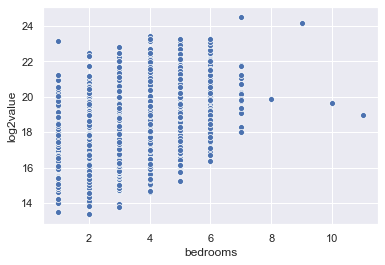

In [43]:
sns.scatterplot(x='bedrooms', y = 'log2value', data=train)

# May be we should try to fit a polynomial function to predict price using log2sf

In [44]:
X_train = train[[ 'log2sf', 'log2_zip_median', 'bathrooms']]
y_train = train[['log2value']]
X_test = test[['log2sf', 'bathrooms']]
y_test = test[['log2value']]

In [45]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
#poly.get_feature_names()

In [46]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [47]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['assessed_value'].median()

In [48]:
y_train.head(2)

,log2value,log_predicted_poly,actual,poly_predicted
11938,18.034869,18.092407,268557.0,279484.118630
790,16.548476,18.530351,95849.0,378609.481011


In [49]:
#y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

float('{:.1f}'.format(median_absolute_error(y_train.actual, y_train.poly_predicted)))

152438.3

In [50]:
#y_train.apply(lambda col: r2_score(y_train.actual, col))

float('{:.3f}'.format(r2_score(y_train.actual, y_train.poly_predicted)))

0.501

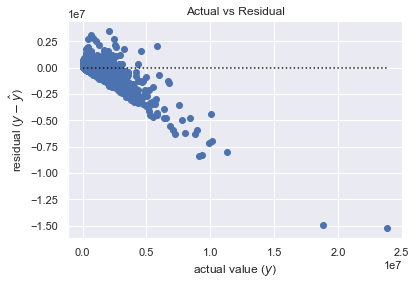

In [51]:
evaluate.plot_residuals(y_train.actual, y_train.poly_predicted, y_train)

# Polynomial Linear  Regression Summary:
# Median Absolute Error: 152,438
# R2 value: 0.501

***

# Generalized Additive Model (GAM)

In [144]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [166]:
X_train = train[['bathrooms', 'log2sf', 'log2_zip_median', 'latitude', 'longitude']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median','latitude', 'longitude']]
y_test = test[['log2value']]

In [167]:
#scaler, X_train_scaled, X_test_scaled = split_scale.min_max_scaler(X_train, X_test)

In [168]:
X_train= X_train.to_numpy()
y_train = y_train.to_numpy()

In [169]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2) +te(3,4))

In [170]:
gam.gridsearch(X_train,y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + te(3, 4) + intercept, tol=0.0001, 
   verbose=False)

In [171]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.6472
Link Function:                     IdentityLink Log Likelihood:                                -14888.7661
Number of Samples:                        10411 AIC:                                            29820.8267
                                                AICc:                                           29820.9211
                                                GCV:                                                1.0279
                                                Scale:                                              1.0243
                                                Pseudo R-Squared:                                   0.4571
Feature Function                  Lam

In [172]:
y_pred = gam.predict(X_train)

In [173]:
y_pred

array([17.90045   , 18.51572899, 18.68060713, ..., 17.91915648,
       19.24742209, 17.37548168])

In [174]:
y_pred = pd.DataFrame(y_pred)

In [175]:
y_pred['actual'] =y_train

In [176]:
y_pred['actual1'] = 2**y_pred.actual
y_pred['predicted1'] = 2**y_pred[0]

In [177]:
y_pred['residual'] = y_pred.actual1-y_pred['predicted1']

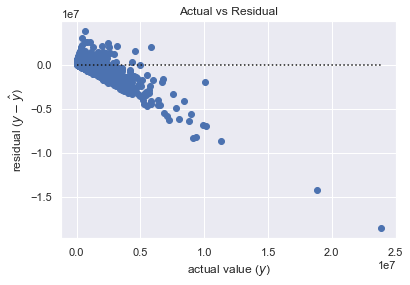

In [178]:
evaluate.plot_residuals(y_pred.actual1, y_pred['predicted1'], y_pred)

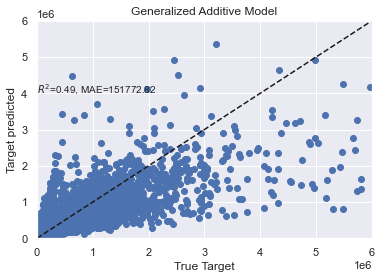

In [179]:
explore.plot_scatter(y_pred['actual1'], y_pred['predicted1'])

In [180]:
float('{:.1f}'.format(median_absolute_error(y_pred.actual1, y_pred.predicted1)))

151772.8

In [181]:
float('{:.3f}'.format(r2_score(y_pred.actual1, y_pred.predicted1)))

0.493

## GAM Summary with test data
## Median Absolute Error: 151,772
## R2 value: 0.493

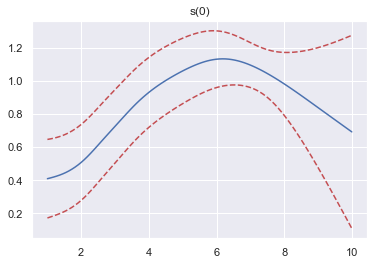

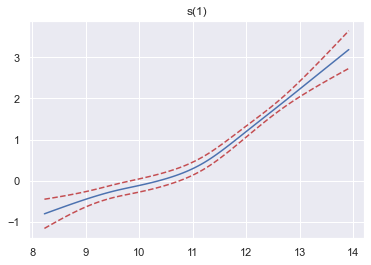

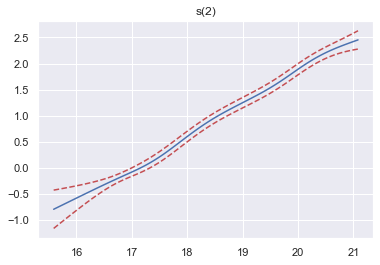

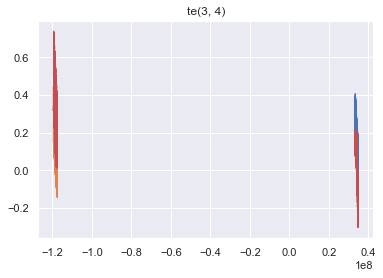

In [196]:
# Lets plot partial dependence plots for each term in GAM model above
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

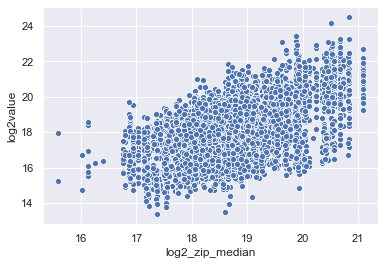

In [183]:
sns.scatterplot(x='log2_zip_median', y = 'log2value', data=train)

# Lets try a polynomial linear model with X_train = train[['bathrooms', 'log2sf', 'latitude', 'longitude']]

In [184]:
X_train = train[['bathrooms', 'log2sf','log2_zip_median']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median']]
y_test = test[['log2value']]
X_train1 = df[['bathrooms', 'log2sf','log2_zip_median']]
y_train1 = df[['log2value']]

In [185]:
# X_train = train[['bathrooms', 'log2sf', 'log2_zip_median','latitude', 'longitude']]
# y_train = train[['assessed_value']]
# X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median','latitude', 'longitude']]
# y_test = test[['assessed_value']]

In [187]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
#poly.get_feature_names()

In [188]:
X_poly = pd.DataFrame(poly.transform(X_train), columns=poly.get_feature_names(X_train.columns))
X_poly.head(2)

,1,bathrooms,log2sf,log2_zip_median,bathrooms^2,bathrooms log2sf,bathrooms log2_zip_median,log2sf^2,log2sf log2_zip_median,log2_zip_median^2,bathrooms^3,bathrooms^2 log2sf,bathrooms^2 log2_zip_median,bathrooms log2sf^2,bathrooms log2sf log2_zip_median,bathrooms log2_zip_median^2,log2sf^3,log2sf^2 log2_zip_median,log2sf log2_zip_median^2,log2_zip_median^3
0,1.000,3.000,11.057,17.865,9.000,33.170,53.595,122.249,197.525,319.154,27.000,99.510,160.784,366.748,592.576,957.461,1351.666,2183.967,3528.765,5701.637
1,1.000,2.000,10.736,19.117,4.000,21.471,38.235,115.252,205.235,365.473,8.000,42.942,76.469,230.504,410.471,730.946,1237.296,2203.316,3923.555,6986.873


In [189]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [191]:
y_train.head(2)

,log2value,log_predicted_poly
11938,18.035,18.092
790,16.548,18.530


In [192]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['log2value'].median()

In [193]:
y_train.head(2)
#y_train.to_csv('poly2_non_spatial.csv')

,log2value,log_predicted_poly,actual,poly_predicted
11938,18.035,18.092,268557.000,279484.119
790,16.548,18.530,95849.000,378609.481


In [198]:
float('{:.1f}'.format(median_absolute_error(y_train.actual, y_train.poly_predicted)))

152438.3

In [202]:
float('{:.3f}'.format(r2_score(y_train.actual, y_train.poly_predicted)))

0.501

## Polynomial Linear  Regression Summary:
## Median Absolute Error: 152,438
## R2 value: 0.501

-----------------------------------------------------

# Lets try Ridge Regressions with cross-validation

In [253]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [254]:
X_train = train[[ 'square_feet','bathrooms','zip_median','latitude', 'longitude']]
y_train = train[['assessed_value']]
X_test = test[['log2sf','bathrooms','latitude', 'longitude']]
y_test = test[['log2value']]

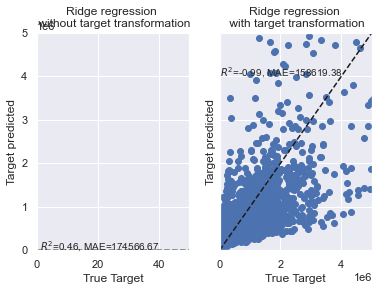

In [268]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)

ax0.scatter(y_train, y_pred)
ax0.plot([0, 50], [0, 50], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 40, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax0.set_xlim([0, 50])
ax0.set_ylim([0, 50])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_train)

ax1.scatter(y_train, y_pred)
ax1.plot([0, 50000000], [0, 50000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax1.set_xlim([0, 5000000])
ax1.set_ylim([0, 5000000])

#f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

In [257]:
y_pred = pd.DataFrame(y_pred, columns = ['predicted_log'],index=y_train.index)

In [258]:
y_pred.head(2)

,predicted_log
11938,271881.352
790,375282.992


In [259]:
y_pred1 = train[['assessed_value']]

In [260]:
y_pred1.head(2)

,assessed_value
11938,268557.000
790,95849.000


In [261]:
df1 = pd.concat([y_pred, y_pred1], axis=1)

In [262]:
df1.head(2)

,predicted_log,assessed_value
11938,271881.352,268557.000
790,375282.992,95849.000


In [224]:
df1['predicted1'] = 2**df1.predicted_log

In [270]:
df1.head(2)

,predicted_log,assessed_value
11938,271881.352,268557.000
790,375282.992,95849.000


In [264]:
df1.apply(lambda col: median_absolute_error(df1.assessed_value, col))

predicted_log    158619.378
assessed_value        0.000
dtype: float64

In [265]:
df1.apply(lambda col: r2_score(df1.assessed_value, col))

predicted_log    -0.987
assessed_value    1.000
dtype: float64

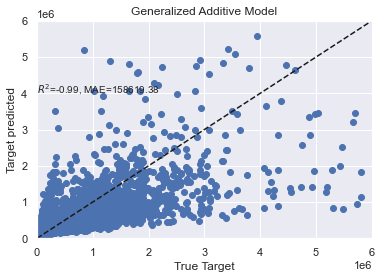

In [271]:
explore.plot_scatter(df1['assessed_value'], df1['predicted_log'])

# Ridge Regression Summary:
# Median Absolute Error: 159,076
# R2 value: 0.316

----------------------------------------

# Lets now try to remove outliers and then do modeling

In [96]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median,haversine_distance
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,...,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30,144172.0,17.137431,21.546420
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,...,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89,162337.0,17.308632,88.899173


In [97]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [98]:
train = train[train.assessed_value< 1000000]

In [99]:
#train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'assessed_value', 'lot_size']]

In [100]:
#explore.plot_variable_pairs(train_plot)

In [101]:
#bath_cutoff = train.bathrooms.mean() + 3*train.bathrooms.std()

In [102]:
#bed_cutoff = train.bedrooms.mean() + 3*train.bedrooms.std()

In [103]:
#sf_cutoff = train.square_feet.mean() + 3*train.square_feet.std()

In [104]:
#bath_cutoff, bed_cutoff , sf_cutoff

In [105]:
#train = train[train.bathrooms<bath_cutoff][train.bedrooms<bed_cutoff][train.square_feet<sf_cutoff]

In [106]:
#train.assessed_value.max()

In [107]:
#outliers = train[train.assessed_value>1000000]

In [108]:
#outliers.info()

In [109]:
#outliers_plot = outliers[['bathrooms', 'bedrooms', 'square_feet', 'assessed_value', 'lot_size']]

In [110]:
#explore.plot_variable_pairs(outliers_plot)

In [111]:
X_train = train[['bedrooms', 'bathrooms', 'log2sf']]
y_train = train[['log2value']]
X_test = test[['bedrooms', 'bathrooms', 'log2sf']]
y_test = test[['log2value']]

In [112]:
predictions = pd.DataFrame({
    'actual_log': y_train.log2value
})
predictions.head(2)

,actual_log
11938,18.034869
790,16.548476


In [113]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('log2value ~ bedrooms + bathrooms + log2sf', data = train).fit()

# compute predictions and add to original dataframe
predictions['ols_log'] = ols_model.predict(X_train)

In [114]:
predictions['actual'] = 2**predictions.actual_log
predictions['ols_predicted'] = 2**predictions.ols_log

In [115]:
(2**y_train.log2value).mean()

377045.96587841486

In [116]:
predictions.head()

,actual_log,ols_log,actual,ols_predicted
11938,18.034869,18.664083,268557.0,415383.094646
790,16.548476,18.034819,95849.0,268547.775038
3846,18.308361,18.380399,324613.0,341233.327511
14846,18.931165,18.784821,499860.0,451642.276272
1469,18.981971,17.946658,517777.0,252628.506851


In [117]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: median_absolute_error(predictions.actual, col))

actual_log      344368.606
ols_log         344368.530
actual               0.000
ols_predicted   156431.636
dtype: float64

In [118]:
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual_log      446394.657
ols_log         446395.111
actual               0.000
ols_predicted   223132.376
dtype: float64

In [119]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log2value   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     672.6
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:41:46   Log-Likelihood:                -13684.
No. Observations:                9261   AIC:                         2.738e+04
Df Residuals:                    9257   BIC:                         2.740e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0172      0.337     29.725      0.000       9.357      10.678
bedrooms      -0.1616      0.017     -9.469      0.000      -0.195      -0.128
bathrooms      0.2218      0.024      9.389      0.000       0.176       0.268
log2sf         0.7657      0.036     21.006      0.000       0.694       0.837
==============================================================================
Omnibus:                      629.231   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              731.158
Skew:                          -0.671   Prob(JB):                    1.70e-159
Kurtosis:                       2.697   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
predictions2 = pd.DataFrame({
    'actual_log': y_test.log2value
})
predictions2.head(2)

,actual_log
9116,20.367
2397,19.605


In [121]:
predictions2['test_ols_log'] = ols_model.predict(X_test)

In [122]:
predictions2['actual'] = 2**predictions2.actual_log
predictions2['test_ols_predicted'] = 2**predictions2.test_ols_log

In [123]:
predictions2.head(2)

,actual_log,test_ols_log,actual,test_ols_predicted
9116,20.367,18.978,1352462.000,516348.014
2397,19.605,18.839,797339.000,468927.282


In [124]:
predictions2.apply(lambda col: median_absolute_error(predictions2.actual, col))

actual_log           371192.998
test_ols_log         371193.006
actual                    0.000
test_ols_predicted   171045.651
dtype: float64

# It is wierd that removing outliers led to higher Median Absolute Error(MAE) on OLS model. However, the MAE is better on test model. 

Lets built a GLM and and then input that in Gamma GAM

In [125]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median,haversine_distance
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,...,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30,144172.000,17.137,21.546
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,...,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89,162337.000,17.309,88.899


In [126]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [127]:
X_train = train[['square_feet', 'zip_median']]
y_train = train[['log2value']]

In [128]:
lm = LinearRegression()

In [129]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [130]:
X_train['predicted_log_value'] = lm.predict(X_train)

In [131]:
X_train

,square_feet,zip_median,predicted_log_value
11938,2130.000,238705.000,18.128
790,1705.000,568715.000,18.409
3846,2014.000,568506.500,18.579
14846,2376.000,496144.000,18.666
1469,1360.000,397974.000,17.951
...,...,...,...
12119,2593.000,1072104.000,19.687
8039,1357.000,361812.000,17.893
14147,1453.000,298307.500,17.846
6936,2555.000,750000.000,19.162


In [132]:
X_train['longitude'] = train['longitude']
X_train['latitude'] = train['latitude']

In [133]:
X_train.head(2)

,square_feet,zip_median,predicted_log_value,longitude,latitude
11938,2130.000,238705.000,18.128,-118185301.000,34663693.000
790,1705.000,568715.000,18.409,-118607295.000,34178821.000


In [134]:
X_train = X_train.drop(columns=['square_feet', 'zip_median'])

In [135]:
X_train.head(2)

,predicted_log_value,longitude,latitude
11938,18.128,-118185301.000,34663693.000
790,18.409,-118607295.000,34178821.000


In [136]:
X_train= X_train.to_numpy()
y_train = y_train.to_numpy()

In [137]:
X_train[0]

array([ 1.81275456e+01, -1.18185301e+08,  3.46636930e+07])

In [138]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(terms = te(1,2) + isintercept.(predicted_log_value))

SyntaxError: invalid syntax (<ipython-input-138-0f4b67ac4869>, line 2)

In [ ]:
gam.gridsearch(X_train, y_train)

In [ ]:
gam.summary()

In [ ]:
y_pred = gam.predict(X_train)
y_pred = pd.DataFrame(y_pred)

In [ ]:
y_pred['actual'] = y_train

In [ ]:
y_pred

In [ ]:
y_pred['actual1'] = 2**y_pred.actual
y_pred['predicted1'] = 2**y_pred[0]

In [ ]:
f, (ax1) = plt.subplots(1, 1)

ax1.scatter(y_pred['actual1'], y_pred['predicted1'])
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Generalized Additive Model')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_pred['actual1'], y_pred['predicted1']), median_absolute_error(y_pred['actual1'], y_pred['predicted1'])))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

#f.tight_layout(rect=[0.8, 0.8, 0.95, 0.95])

plt.show()

In [ ]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual1, col))

In [ ]:
y_pred.apply(lambda col: r2_score(y_pred.actual1, col))

In [ ]:
evaluate.plot_residuals(y_pred.actual1, y_pred['predicted1'], y_pred)

## -----------GAM simulations with non-log parameters-------


In [ ]:
X_train = train[['bathrooms', 'square_feet', 'zip_median']]
y_train = train[['assessed_value']]
X_test = test[['bathrooms', 'square_feet', 'zip_median', 'latitude', 'longitude']]
y_test = test[['assessed_value']]
X_test1 = df[['bathrooms', 'square_feet', 'zip_median','latitude', 'longitude']]
y_test1 = df[['assessed_value']]

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [ ]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2))

In [ ]:
gam.gridsearch(X_train,y_train)

In [ ]:
y_pred = gam.predict(X_train)

In [ ]:
y_pred = pd.DataFrame(y_pred)
#y_pred.to_csv('GAM-spatial.csv')

In [ ]:
y_pred['actual'] = y_train

In [ ]:
f, (ax1) = plt.subplots(1, 1)


ax1.scatter(y_pred['actual'], y_pred[0])
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Generalized Additive Model')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_pred['actual'], y_pred[0]), median_absolute_error(y_pred['actual'], y_pred[0])))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

#f.tight_layout(rect=[0.8, 0.8, 0.95, 0.95])

plt.show()

In [ ]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual, col))

In [ ]:
y_pred.apply(lambda col: r2_score(y_pred.actual, col))